Lightly edited for clarity as Noah goes through this...

# To Discuss: 
When we combine the code, maybe we should not introduce u straight up but after we demonstrate the basic ideas underlying our SIR model. In this notebook I basically modified the base model with the policy intervention term `u`, but in Noah's version of the same notebook there will still be a basic example without `u`.

In [ ]:
from pdb import set_trace

from pdb import set_trace

Disease modeling can be done at the population-level by assuming a global mathematical model that abstracts away individual level effects. A compartmental model is one such model that divides the population of individuals into different states or compartments at each point in time. The general idea is that individuals in a population are interacting with each other and as a result of this interaction they may transition from one compartment to another with a particular transition probability. Since all individuals are assumed to be equal, this transition need only be represented by a global transition probability between every set of subsequent compartments which encapsulates the notion of 'spread' of disease through a population through individual-level compartmental transitions. It helps that in practice, in addition to the number of deaths, the fraction of total population in the infected state/compartment at a particular time is also what we typically utilise in public awareness campaigns, which can be obtained directly from a compartmental model. 

We will start by looking at a simple compartmental model and move to more complicated models that better capture population interaction and the progression of disease spread. Unless specified, our explanations will reference discrete time steps although as the plots can confirm, this is easily understood in terms of a continuous variable.

## The SIR Model

### Model Dynamics

- We work with the assumption that the total population is constant, ignoring new births and deaths for the time being, in this simplistic setup for epidemiological modeling of COVID-19.
- write down the differential equations for SIR
- explain why the rate of change of the susceptible population S at time t depends on the fraction of infected population at that time i(t) (hint: number of infectious contacts relies on the fraction i(t) of infected people in the population times the total number of contacts times the transmission probability--defined as the probability that an infectious contact may result in a spread of the disease).
- the transition from state I to R is fairly straightforward and obtained directly from the rate of recovery of the infected population.
- Consider model parameters $\beta$ and $\gamma$ where $\beta$ represents the transmission probability of the disease and $\gamma$ represents the recovery rate. The model infectiousness or reproduction number $R_0$ is defined as $\frac{\beta}{\gamma}$.
- These dynamics are encapsulated in the following differential equations representing the mathematical model for SIR.
- Note that we should formally only use S(t), I(t) and R(t) but we sometimes omit it for simplicity (right?)
$$
s(t) + i(t) + r(t) = 1 \\
\frac{dS}{dt} = -\beta S(t) i(t) \\
\frac{dI}{dt} = \beta S(t) i(t) - \gamma I(t) \\
\frac{dR}{dt} = \gamma I(t)
$$

Worth reading [this for a better example of solving these systems of equations mathematically](http://sherrytowers.com/2013/12/11/introduction-to-compartmental-modeling/) plus the three links at the bottom of her page describing interesting extensions to vanilla SIR models through sub-grouping the data.

In [ ]:
# Adapted from https://pyro.ai/examples/sir_hmc.html by Swapneel and Noah

In [2]:
import argparse
import logging
import math
import re
from collections import OrderedDict

import torch
from torch import distributions as tdist
from pyro import distributions as dist

from matplotlib import pyplot as plt
import seaborn as sns
import logging

import pyro.distributions as dist
import pyro.distributions.hmm
import pyro.poutine as poutine
from pyro.infer import MCMC, NUTS, config_enumerate, infer_discrete
from pyro.infer.autoguide import init_to_value
from pyro.ops.special import safe_log
from pyro.ops.tensor_utils import convolve
from pyro.util import warn_if_nan
#plt.style.use('dark_background')

logging.basicConfig(format='%(message)s', level=logging.INFO)


/app/python/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


Trying to run this. Memory gets used up. Will update as I go. 

### 1. The Priors we place on R0 and $\rho$

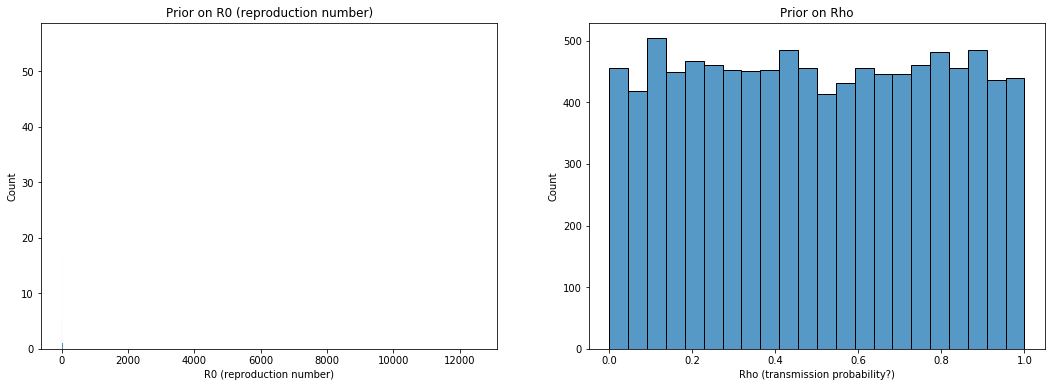

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

r0_prior = tdist.LogNormal(0., 1.)
r0_samples = r0_prior.sample(torch.Size([100]))
sns.histplot(r0_samples[r0_samples < 10].exp(), ax=ax[0])
ax[0].set_xlabel('R0 (reproduction number)')
ax[0].set_title('Prior on R0 (reproduction number)')

rho_prior = tdist.Uniform(0., 1.)
rho_samples = rho_prior.sample(torch.Size([10000]))
sns.histplot(rho_samples, ax=ax[1])
ax[1].set_xlabel('Rho (transmission probability?)')
ax[1].set_title('Prior on Rho')

plt.show()

In [56]:
def global_model(population):
    """
    From the population and initial values for recovery time, R0, and rho, convert interpretable values
    
    (an epidemiologist knows what R0 is but not rate_s), into the parameters needed for the distribution. 
    
    
    Returns
    -------
    
    rate_s: rate of infection i 
    
    prob_i: probality of infection? 
    
    rho: not sure yet. 
    
    u: effect of policy intervention
    """
    tau = args.recovery_time  # Assume this can be measured exactly... TODO: Why not make this also a dist? 
    R0 = pyro.sample("R0", dist.LogNormal(0., 1.)) # these are priors on what we considered args. 
    rho = pyro.sample("rho", dist.Uniform(0, 1))
    
    # Convert interpretable parameters to distribution parameters.
    # rate_s = - R0 / (tau * population)  # I don't see the intuition behind this because for larger populations this foews close to 0
    rate_s = - R0 / (tau * population)
    prob_i = 1 / (1 + tau)

    return rate_s, prob_i, rho


def discrete_model(args, data):
    """
    create discrete model 
    
    This enumerates through the data, and computes what the actual S and I (and therefore R) values R at each timestep, 
    and saves in a messy dictionary under poutine. 
    
    This messy info is then saved in a more ordered format through 
    """
    # Sample global parameters.
    rate_s, prob_i, rho = global_model(args.population) # global parameters are what the current estimates are. 
    
    # Introduce policy intervention parameter 'u' that limits the rate of spread of disease
    # This can technically just be uniformly drawn from (0, 1) but it is more realistic 
    # to limit it to less than 1 because no intervention can be perfect enough to
    # completely curtail a disease.
    if args.policy_intervention > 0:
        # u = pyro.param("u", torch.tensor([args.policy_intervention]))
        u = pyro.sample("u", dist.Normal(args.policy_intervention, 0.05))
        rate_s = (1 - u) * rate_s
        
    # Sequentially sample time-local variables.
    S = torch.tensor(args.population - 1.)
    I = torch.tensor(1.)
    for t, datum in enumerate(data): # for data point in dataset, use this distribution to  
        S2I = pyro.sample("S2I_{}".format(t),
                          dist.Binomial(S, -(rate_s * I).expm1())) # the actual formula 
        I2R = pyro.sample("I2R_{}".format(t),
                          dist.Binomial(I, prob_i))
        S = pyro.deterministic("S_{}".format(t), S - S2I) 
        I = pyro.deterministic("I_{}".format(t), I + S2I - I2R) # the diff eqs 
        pyro.sample("obs_{}".format(t),
                    dist.ExtendedBinomial(S2I, rho),
                    obs=datum)
        


## Discretizing the Model

In the SIR model above, the authors redefine the population-level disease parameters we discussed for the SIR model (transmission probability $\beta$ and recovery rate $\gamma$) in terms of certain measurable quantities such as the recovery time $\tau$ and the initial estimates of the reproduction number $R_0$ and response rate $\rho$.

Binomial versus ExtendedBinomial (pyro, experimental). The idea behind the last line in the discrete_model defined below is that after calculating the S2I transitions we sample from a binomial distribution that has a support over the space of integers with a probability $\rho$ so let's first see how that looks. In the diagram below you see that rho is essentially equivalent to sampling from a binomial distribution that with a certain probability *could* result in such a count of S2I transitions. Hopefully this offers some intuition into what the response rate $\rho$ represents. While this model does not follow an identical transition process from $S$ to $I$ as described in the SIR model dynamics, $\rho$ operates in a manner similar to the transition probability $\beta$ in that it determines how likely it is that the model will generate a particular number of successful infections.

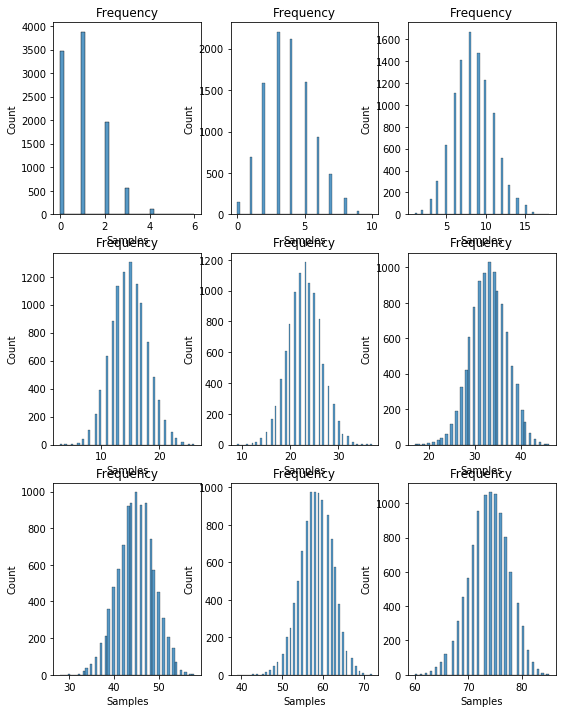

In [57]:
fig, ax = plt.subplots(3,3, figsize=(9,12))
dummyS2I = torch.arange(10, 100, 10)
dummyrho = torch.arange(0.1, 0.99, 0.09)
count = 0
for i in range(3):
    for j in range(3):
        dummydist = dist.ExtendedBinomial(dummyS2I[count], dummyrho[count])
        dummysamples = dummydist.sample(torch.Size([10000]))
        sns.histplot(dummysamples, ax=ax[i, j])
        ax[i, j].set_xlabel('Samples')
        ax[i, j].set_title('Frequency')
        count += 1

plt.show()

In [58]:
# We can use this model to simulate data. We'll use poutine.condition to pin
# parameter values and poutine.trace to record sample observations.

def generate_data(args):
    """
    Simulate data. 
    
    Using args to input initial estimates on R0 and other epidemiology jargon, return a list of the compartment populations
    according to these conditions. 
    
    Policy interventions have been simulated using the parameter 'u' based on the paper by F. Wood and team. 
    We add a max_observations argument so that we can simulate data with an upper limit for number of infections with the same
    values of R0 and rho as we did in the case with no policy intervention.
    
    S2I, I2R
    """
    logging.info("Generating data...")
    params = {"R0": torch.tensor(args.basic_reproduction_number), #what we set 
              "rho": torch.tensor(args.response_rate)}
    empty_data = [None] * (args.duration + args.forecast)

    # We'll retry until we get an actual outbreak -> this implies at least args.min_observations infections are observed
    for attempt in range(100):
        with poutine.trace() as tr:
            with poutine.condition(data=params):
                discrete_model(args, empty_data)

        # Concatenate sequential time series into tensors.
        obs = torch.stack([site["value"]
                           for name, site in tr.trace.nodes.items()
                           if re.match("obs_[0-9]+", name)])
        S2I = torch.stack([site["value"]
                          for name, site in tr.trace.nodes.items()
                          if re.match("S2I_[0-9]+", name)])
    
        I2R = torch.stack([site["value"]
                          for name, site in tr.trace.nodes.items()
                          if re.match("I2R_[0-9]+", name)])
        
        assert len(obs) == len(empty_data)

        obs_sum = int(obs[:args.duration].sum())
        S2I_sum = int(S2I[:args.duration].sum())
        I2R_sum = int(I2R[:args.duration].sum())

        # we only need max observations if we do not use u, 
        # or if we want to generate data without using u
#         if args.max_observations > 0:
#             if obs_sum <= args.max_observations and obs_sum >= args.min_observations:
#                 logging.info("Observed {:d}/{:d} infections:\n{}".format(
#                     obs_sum, S2I_sum, I2R_sum, " ".join([str(int(x)) for x in obs[:args.duration]])))
#                 return {"S2I": S2I, "obs": obs, "I2R": I2R}

#         else:
        if obs_sum >= args.min_observations:
            logging.info("Observed {:d}/{:d} infections: \n{}".format(
                obs_sum, S2I_sum, I2R_sum, " ".join([str(int(x)) for x in obs[:args.duration]])))
            return {"S2I": S2I, "obs": obs, "I2R": I2R}

    raise ValueError("Failed to generate min: {} and max: {} observations. Try increasing "
                     "--population, increasing --max-observations or decreasing --min-observations"
                     .format(args.min_observations, args.max_observations))



In [66]:
from argparse import Namespace
args = Namespace(population=1000, 
                 min_observations=10,
                 max_observations=800,
                 duration=180,
                 forecast=25, 
                 basic_reproduction_number=1.5,  # what our epidemic's R0 is.
                 recovery_time=7.0,  #recovery timne. These values are 
                 response_rate=0.8,  # this is the probability of observed infections (noisy)
                 enum=True, 
                 sequential=True, 
                 num_samples=1000, 
                 warmup_steps=100, 
                 max_tree_depth=5, 
                 rng_seed=0, 
                 double=True, 
                 jit=True, 
                 cuda=True, 
                 verbose=True, 
                 plot=True,
                 policy_intervention=0)

### Data Generation Process

The way pyro performs inference over discrete latent variables is through enumeration. It defines a set of effect handlers under the hood in order to freely allow new inference algorithms to be developed without having to dig into its internal implementations. Poutine is a library of composable effect handlers that can be used to develop such algorithms. For our use-case, poutine can be used to condition a model on some observable data. But in addition to that, imagine using poputine to run the model forward **without conditioning on any observed data** just to use it as a forward simulator. That is exactly what this data generating process is doing. 

The generate_data function conditions the model on an "observed dataset" which is essentially a list of null values and in doing so it allows the model to run unconditionally to generate a sample time-series of infection spread based on the model parameters (here, $R_0$ and $\rho$). Then, it checks if the generated time-series satisfies a certain constraint based on which it either accepts or rejects the entire simulated trajectory. It does this by going back and checking the 'trace' produced by the forward simulation.

Implementation-wise, it runs a simulation for `args.duration` timesteps and discards simulated trajectories until it satisfies a constraint of total infections being at least `args.min_observations` for a population of `args.population` individuals.

In [67]:
x = generate_data(args)

Generating data...
Observed 551/690 infections: 
690


In [68]:
x

{'S2I': tensor([ 0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,
          0.,  0.,  1.,  0.,  0.,  2.,  2.,  0.,  0.,  0.,  1.,  0.,  2.,  1.,
          0.,  1.,  3.,  3.,  4.,  5.,  0.,  3.,  3.,  2.,  5.,  0.,  4.,  4.,
          4.,  6.,  3.,  5.,  6.,  5.,  9.,  4.,  7.,  8.,  6., 11.,  8.,  8.,
         12., 13., 13., 12., 11., 11.,  8., 11., 11., 10.,  9., 15., 13., 17.,
         14., 11., 15., 17.,  9., 12., 13., 14.,  9., 15., 13., 16., 13.,  9.,
          8., 14., 12., 10.,  9.,  5.,  2.,  5.,  4.,  6.,  9.,  2.,  6.,  5.,
          6.,  6.,  2.,  2.,  3.,  3.,  6.,  5.,  5.,  3.,  1.,  4.,  3.,  2.,
          4.,  2.,  3.,  4.,  2.,  1.,  2.,  1.,  3.,  1.,  2.,  3.,  4.,  2.,
          1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  2.,  0.,  1.,
          0.,  1.,  3.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  1.,  1.,  0.,  0.,  

# Visualizing the Generated Infection Spread

So far we have defined our model in terms of transitions `S2I` and `I2R` and we only assume that we noisily observe the number of infections based on the response rate $\rho$. The plot below shows these values with the corresponding axes as labeled.

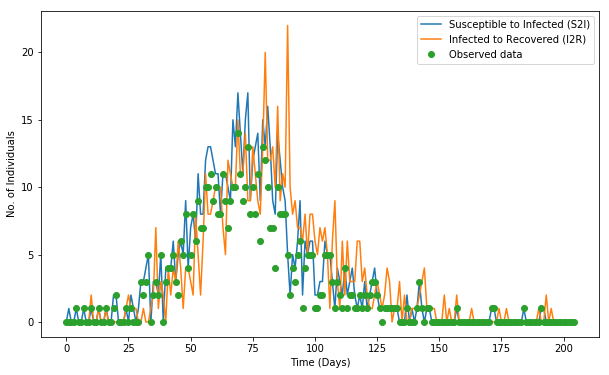

In [69]:
figure = plt.figure(figsize=(10, 6))
plt.plot(x['S2I'],label='Susceptible to Infected (S2I)')
plt.plot(x['I2R'],label='Infected to Recovered (I2R)')
plt.plot(x['obs'],'o',label='Observed data')
plt.xlabel('Time (Days)')
plt.ylabel('No. of Individuals')
plt.legend()

While the figure does tell us about the true and observed spread, it would be much easier to visualize this if we could model the individual compartments over time using the sum total of individuals belonging to each compartment at each discrete time-step and interpolating between them for ease of visualization. Furthermore, when performing inference, it is harder to marginalize by enumerating these discrete random variables. This is where we can introduce a reparametrization of the original model in terms of $S$, $I$, and implicitly, $R$ using the idea that $S + I + R$ = total population.

## Impact of Varying Policy Interventions (u) on SIR Model

Generating data...
Observed 566/686 infections: 
687
/app/python/matplotlib/axes/_base.py:3364: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=100.0, top=100.0
  self.set_ylim(upper, lower, auto=None)
Generating data...
Observed 468/584 infections: 
584
Generating data...
Observed 417/506 infections: 
507
Generating data...
Observed 319/390 infections: 
389
Generating data...
Observed 279/347 infections: 
345
Generating data...
Observed 222/283 infections: 
277
Generating data...
Observed 92/114 infections: 
110
Generating data...
Observed 23/28 infections: 
29
Generating data...
Observed 13/20 infections: 
21


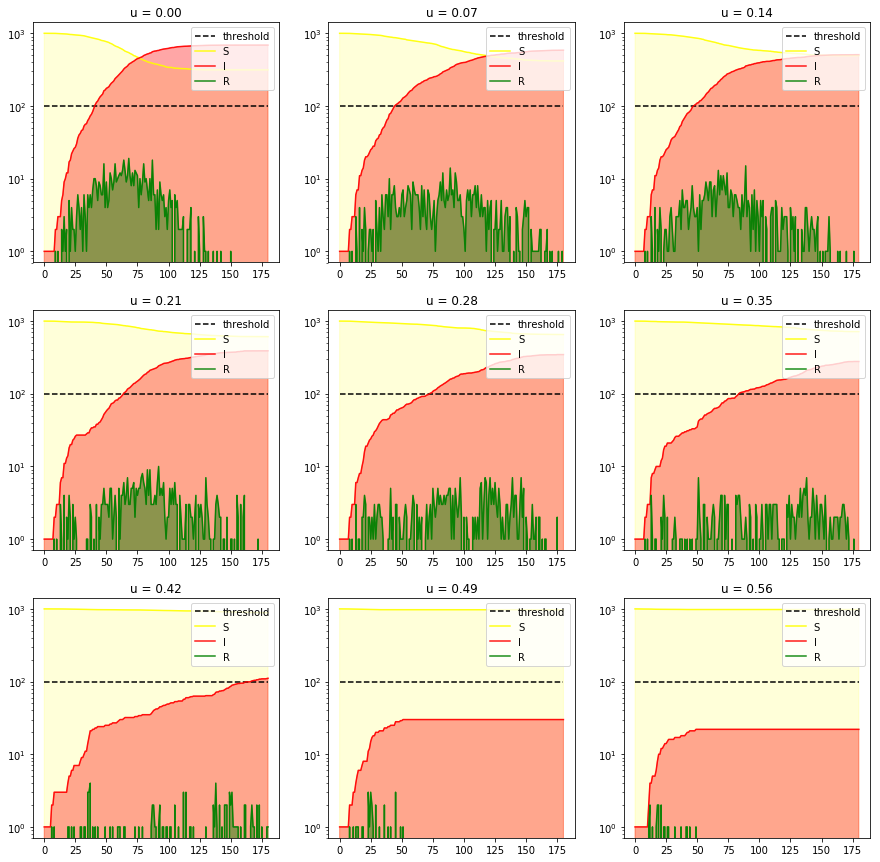

In [74]:
import numpy as np
np.random.seed(1234)

fig, ax = plt.subplots(3,3, figsize=(15,15))
dummyu = np.arange(0, 0.7, 0.07)
count = 0
for ii in range(3):   # since i is used for the compartmental model
    for j in range(3):
        args.policy_intervention = dummyu[count]
        if args.policy_intervention > 0.8:
            args.min_observations = 0

        torch.manual_seed(1234)
        pyro.set_rng_seed(1234)
        
        try:
            data = generate_data(args)
        except ValueError as e:
            print("Could not generate enough meaningful populations, \
                  increase number of attempts or consider changing min/max obs")
            continue

        _S = [args.population]
        _I = [1]
        _R = [0]

        for t in range(args.duration):
            s = _S[t] - data['S2I'][t]
            i = _I[t] + data['I2R'][t]
            r = data['I2R'][t]
            _S.append(s)
            _I.append(i)
            _R.append(r)
            
        _S = torch.tensor(_S)
        _I = torch.tensor(_I)
        _R = torch.tensor(_R)
        
        x_vals = np.arange(0, len(_S), 1)  # length of all arrays is the same as duration
        # plot the threshold
        ax[ii, j].plot([args.population/10]*len(_S), label='threshold', color='black', linestyle='dashed')
        
        ax[ii, j].set_yscale('log')        
        ax[ii, j].plot(_S, label='S', color='yellow', alpha=0.9)
        ax[ii, j].fill_between(x_vals, _S, color='yellow', alpha=0.15)
        ax[ii, j].plot(_I, label='I', color='red', alpha=0.9)
        ax[ii, j].fill_between(x_vals, _I, color='red', alpha=0.35)
        ax[ii, j].plot(_R, label='R', color='green', alpha=0.9)
        ax[ii, j].fill_between(x_vals, _R, color='green', alpha=0.45)
        ax[ii, j].legend(loc="upper right")
        ax[ii, j].set_title("u = {:.2f}".format(args.policy_intervention))
        count += 1

In [71]:
_S[t], _I[t], _R[t]

(tensor(0.9800), tensor(0.0220), tensor(0.))

In [ ]:
# Inference
# =========
#
# While the above discrete_model is easy to understand, its discrete latent
# variables pose a challenge for inference. One of the most popular inference
# strategies for such models is Sequential Monte Carlo. However since Pyro and
# PyTorch are stronger in gradient based vectorizable inference algorithms, we
# will instead pursue inference based on Hamiltonian Monte Carlo (HMC).
#
# Our general inference strategy will be to:
# 1. Introduce auxiliary variables to make the model Markov.
# 2. Introduce more auxiliary variables to create a discrete parameterization.
# 3. Marginalize out all remaining discrete latent variables.
# 4. Vectorize to enable parallel-scan temporal filtering.
#
# Let's consider reparameterizing in terms of the variables (S, I) rather than
# (S2I, I2R). Since these may lead to inconsistent states, we need to replace
# the Binomial transition factors (S2I, I2R) with ExtendedBinomial.
#
# The following model is equivalent to the discrete_model:

@config_enumerate
def reparameterized_discrete_model(args, data):
    # Sample global parameters.
    rate_s, prob_i, rho = global_model(args.population) # again, these must be guesses? They have to change somehow.. 

    # Sequentially sample time-local variables.
    S_curr = torch.tensor(args.population - 1.)
    I_curr = torch.tensor(1.)
    for t, datum in enumerate(data):
        # Sample reparameterizing variables.
        # When reparameterizing to a factor graph, we ignored density via
        # .mask(False). Thus distributions are used only for initialization.
        S_prev, I_prev = S_curr, I_curr
        S_curr = pyro.sample("S_{}".format(t),
                             dist.Binomial(args.population, 0.5).mask(False))
        I_curr = pyro.sample("I_{}".format(t),
                             dist.Binomial(args.population, 0.5).mask(False))

        # Now we reverse the computation.
        S2I = S_prev - S_curr
        I2R = I_prev - I_curr + S2I
        pyro.sample("S2I_{}".format(t),
                    dist.ExtendedBinomial(S_prev, -(rate_s * I_prev).expm1()),
                    obs=S2I)
        pyro.sample("I2R_{}".format(t),
                    dist.ExtendedBinomial(I_prev, prob_i),
                    obs=I2R)
        pyro.sample("obs_{}".format(t),
                    dist.ExtendedBinomial(S2I, rho),
                    obs=datum)



### Reparametrization and Auxiliary Variables

First, read the explanation for the reparametrized model offered in the comments above. What they imply is that in their setup they don't directly assume an SIR model in terms of the $S$ ->($\beta$)-> $I$ and $I$ ->($\gamma$)-> $R$ transitions since they use the parameters corresponding to reproduction number $R_0$ and $\rho$ which are a more natural formulation that include quantities of interest for us. When we perform inference, however, it is much easier to work with the model if we can reparametrize it in terms of $\beta$ (transition probability) and $\gamma$ (recovery time) that we originally defined and discuss in the SIR model dynamics section above. Doing this additionally allows us to discretize the time steps and work with the same compartmental model and use real-world data to fit the reparametrized model (params $\beta$, $\gamma$) while still estimating the posterior distributions over $R_0$ and $\rho$. They define `S`, `I`, and implicitly, `R` instead of having to work with `S2I` and `I2R`. This is how we define auxiliary variables in the reparametrized model.

The benefits of reparametrizing models this way will become much clearer in the SEI3R model where have far more complicated model dynamics to work with that can be implemented by reparametrizing the model. For our priors over the model parameters, we rely on estimated confidence intervals obtained from the experiments in recent literature on COVID-19 modeling as specified in the paper.

In [ ]:
# By reparameterizing, we have converted to coordinates that make the model
# Markov. We have also replaced dynamic integer_interval constraints with
# easier static integer_interval constraints (although we'll still need good
# initialization to avoid NANs). Since the discrete latent variables are
# bounded (by population size), we can enumerate out discrete latent variables
# and perform HMC inference over the global latents. However enumeration
# complexity is O(population^4), so this is only feasible for very small
# populations.
#
# Here is an inference approach using an MCMC sampler.




def _infer_hmc(args, data, model, init_values={}):
    """
    Run Hamiltonian Monte Carlo mcmc to estimate parameters R0 and rho
    """
    logging.info("Running inference...")
    kernel = NUTS(model,
                  full_mass=[("R0", "rho")],
                  max_tree_depth=args.max_tree_depth,
                  init_strategy=init_to_value(values=init_values),
                  jit_compile=args.jit, ignore_jit_warnings=True)

    # We'll define a hook_fn to log potential energy values during inference.
    # This is helpful to diagnose whether the chain is mixing.
    energies = []

    def hook_fn(kernel, *unused):
        e = float(kernel._potential_energy_last)
        energies.append(e)
        if args.verbose:
            logging.info("potential = {:0.6g}".format(e))

    mcmc = MCMC(kernel, hook_fn=hook_fn,
                num_samples=args.num_samples,
                warmup_steps=args.warmup_steps)
    mcmc.run(args, data)
    mcmc.summary()
    if args.plot:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(6, 3))
        plt.plot(energies)
        plt.xlabel("MCMC step")
        plt.ylabel("potential energy")
        plt.title("MCMC energy trace")
        plt.tight_layout()

    samples = mcmc.get_samples()
    return samples

def infer_hmc_enum(args, data):
    model = reparameterized_discrete_model
    return _infer_hmc(args, data, model)


### Side Note: For our reference only
Debugging models in Pyro is conventionally done by running them forward and obtaining the trace to sanity check values. Or at least that's one approach to debugging that allows us to inspect what is going on within the model. We can condition the model on the observed data and obtain the values of $R_0$ and $\rho$ from the trace.

In [ ]:
# Noah and Swapneel's Code

In [ ]:
# debugging the model by running it forward and using the observed data to condition it
debug_trace = poutine.trace(reparameterized_discrete_model).get_trace(args, x['obs'])
debug_logp = debug_trace.log_prob_sum()
debug_params = [debug_trace.nodes[name]["value"].unconstrained() for name in debug_trace.param_nodes]
debug_trace.nodes['R0']["value"], debug_trace.nodes['rho']["value"]  # currently no inference is being performed

In [ ]:
def debug_model(model, *args):
    """
    Debugging the model by running it forward and using the observed data to condition it
    
    model specifies the model to be traced
    *args specifies the arguments for the model
    
    returns a poutine.trace object
    
    >> tr_ = debug_model(reparameterized_discrete_model, args, x['obs'])
    """
    debug_trace = poutine.trace(reparameterized_discrete_model).get_trace(*args)
    debug_logp = debug_trace.log_prob_sum()
    debug_params = [debug_trace.nodes[name]["value"].unconstrained() for name in debug_trace.param_nodes]
    return debug_trace

In [ ]:
def extract_samples(varname, _trace):
    """
    Helper function to visualize plots by extracting all samples of a latent variable (S, I, R).
    Filters the nodes by name from trace dict and returns their values. 
    Note: Expects that the variable name is underscore-separated from numeric value e.e. S_0, S_1, ...
    
    >> x = generate_data(args)
    >> debug_trace = poutine.trace(reparameterized_discrete_model).get_trace(args, x['obs'])
    >> extract_samples('S', debug_trace)
    """
    set_trace()
    return [_trace.nodes[nodename]["value"] for nodename in _trace.nodes.keys() if varname==nodename.split('_')[0]]

In [ ]:
## Pyro Official Code

In [ ]:
# To scale to large populations, we'll continue to reparameterize, this time
# replacing each of (S_aux, I_aux) with a combination of a bounded real
# variable and a Categorical variable with only four values.
#
# This is the crux: we can now perform HMC over the real variable and
# marginalize out the Categorical variables using variable elimination.
#
# We first define a helper to create enumerated Categorical sites.

def quantize(name, x_real, min, max):
    """
    Randomly quantize in a way that preserves probability mass.
    We use a piecewise polynomial spline of order 3.
    """
    assert min < max
    lb = x_real.detach().floor()

    # This cubic spline interpolates over the nearest four integers, ensuring
    # piecewise quadratic gradients.
    s = x_real - lb     # s in [0, 1)
    ss = s * s          # ss in [0, 1), ss < s
    t = 1 - s           # t in [0, 1)
    tt = t * t          # tt in [0, 1), tt < t
    probs = torch.stack([
        t * tt,
        4 + ss * (3 * s - 6),
        4 + tt * (3 * t - 6),
        s * ss,
    ], dim=-1) * (1/6)  # this sums probs to 1. so essentially drawing from a uniform over 0 to 3
    q = pyro.sample("Q_" + name, dist.Categorical(probs)).type_as(x_real)

    x = lb + q - 1
    x = torch.max(x, 2 * min - 1 - x)
    x = torch.min(x, 2 * max + 1 - x)

    return pyro.deterministic(name, x)


## Reparametrizing the Model as Continuous

There is another reparametrization that allows us to use a continuous model for generating the samples. However we have to quantize this to allow for enumeration over discrete latent variables during inference. Besides, people cannot be "fractional" so it makes sense to model it thus.

For technical details, chain the custom `debug_model` function and `extract_data` function to obtain plots as we will do following the model definition.

Comments: I am still unclear on the relevance of the cubic spline and piecewise quadratic gradients that we obtain for each discrete time-local variable. I think the idea here is that we want to use HMC which requires only continuous random variables in the model because it calculates the gradient of the distribution with respect to the parameters and runs MCMC until convergence to the stationary distribution. However, it cannot do so with discrete latent variables and so we have to reparametrize the model and enumerate over them. I'm not sure if this makes much sense because of jargon and my little procedural understanding of HMC.


In [ ]:
# Now we can define another equivalent model.

@config_enumerate
def continuous_model(args, data):
    # Sample global parameters.
    rate_s, prob_i, rho = global_model(args.population)

    # Sample reparameterizing variables.
    S_aux = pyro.sample("S_aux",
                        dist.Uniform(-0.5, args.population + 0.5)
                            .mask(False).expand(data.shape).to_event(1))
    I_aux = pyro.sample("I_aux",
                        dist.Uniform(-0.5, args.population + 0.5)
                            .mask(False).expand(data.shape).to_event(1))

    # Sequentially sample time-local variables.
    S_curr = torch.tensor(args.population - 1.)
    I_curr = torch.tensor(1.)
    for t, datum in poutine.markov(enumerate(data)):
        S_prev, I_prev = S_curr, I_curr
        S_curr = quantize("S_{}".format(t), S_aux[..., t], min=0, max=args.population)
        I_curr = quantize("I_{}".format(t), I_aux[..., t], min=0, max=args.population)

        # Now we reverse the computation.
        S2I = S_prev - S_curr
        I2R = I_prev - I_curr + S2I
        pyro.sample("S2I_{}".format(t),
                    dist.ExtendedBinomial(S_prev, -(rate_s * I_prev).expm1()),
                    obs=S2I)
        pyro.sample("I2R_{}".format(t),
                    dist.ExtendedBinomial(I_prev, prob_i),
                    obs=I2R)
        pyro.sample("obs_{}".format(t),
                    dist.ExtendedBinomial(S2I, rho),
                    obs=datum)
        set_trace()

In [ ]:

# Now all latent variables in the continuous_model are either continuous or
# enumerated, so we can use HMC. However we need to take special care with
# constraints because the above Markov reparameterization covers regions of
# hypothesis space that are infeasible (i.e. whose log_prob is -infinity). We
# thus heuristically initialize to a feasible point.

def heuristic_init(args, data):
    """Heuristically initialize to a feasible point."""
    # Start with a single infection.
    S0 = args.population - 1
    # Assume 50% <= response rate <= 100%.
    S2I = data * min(2., (S0 / data.sum()).sqrt()) # smarter guess for ? 
    S_aux = (S0 - S2I.cumsum(-1)).clamp(min=0.5) # clamp 
    # Account for the single initial infection.
    S2I[0] += 1
    # Assume infection lasts less than a month.
    recovery = torch.arange(30.).div(args.recovery_time).neg().exp()
    I_aux = convolve(S2I, recovery)[:len(data)].clamp(min=0.5)

    return {
        "R0": torch.tensor(2.0),
        "rho": torch.tensor(0.5),
        "S_aux": S_aux,
        "I_aux": I_aux,
    }


def infer_hmc_cont(model, args, data):
    init_values = heuristic_init(args, data)
    return _infer_hmc(args, data, model, init_values=init_values)


# Our final inference trick is to vectorize. We can repurpose DiscreteHMM's
# implementation here, but we'll need to manually represent a Markov
# neighborhood of multiple Categorical of size 4 as single joint Categorical
# with 4 * 4 = 16 states, and then manually perform variable elimination (the
# factors here don't quite conform to DiscreteHMM's interface).

def quantize_enumerate(x_real, min, max):
    """
    Randomly quantize in a way that preserves probability mass.
    We use a piecewise polynomial spline of order 3.
    """
    assert min < max
    lb = x_real.detach().floor()

    # This cubic spline interpolates over the nearest four integers, ensuring
    # piecewise quadratic gradients.
    s = x_real - lb
    ss = s * s
    t = 1 - s
    tt = t * t
    probs = torch.stack([
        t * tt,
        4 + ss * (3 * s - 6),
        4 + tt * (3 * t - 6),
        s * ss,
    ], dim=-1) * (1/6)
    logits = safe_log(probs)
    q = torch.arange(-1., 3.)

    x = lb.unsqueeze(-1) + q
    x = torch.max(x, 2 * min - 1 - x)
    x = torch.min(x, 2 * max + 1 - x)
    return x, logits


def vectorized_model(args, data):
    # Sample global parameters.
    rate_s, prob_i, rho = global_model(args.population)

    # Sample reparameterizing variables.
    S_aux = pyro.sample("S_aux",
                        dist.Uniform(-0.5, args.population + 0.5)
                            .mask(False).expand(data.shape).to_event(1))
    I_aux = pyro.sample("I_aux",
                        dist.Uniform(-0.5, args.population + 0.5)
                            .mask(False).expand(data.shape).to_event(1))

    # Manually enumerate.
    S_curr, S_logp = quantize_enumerate(S_aux, min=0, max=args.population)
    I_curr, I_logp = quantize_enumerate(I_aux, min=0, max=args.population)
    # Truncate final value from the right then pad initial value onto the left.
    S_prev = torch.nn.functional.pad(S_curr[:-1], (0, 0, 1, 0), value=args.population - 1)
    I_prev = torch.nn.functional.pad(I_curr[:-1], (0, 0, 1, 0), value=1)
    # Reshape to support broadcasting, similar to EnumMessenger.
    T = len(data)
    Q = 4
    S_prev = S_prev.reshape(T, Q, 1, 1, 1)
    I_prev = I_prev.reshape(T, 1, Q, 1, 1)
    S_curr = S_curr.reshape(T, 1, 1, Q, 1)
    S_logp = S_logp.reshape(T, 1, 1, Q, 1)
    I_curr = I_curr.reshape(T, 1, 1, 1, Q)
    I_logp = I_logp.reshape(T, 1, 1, 1, Q)
    data = data.reshape(T, 1, 1, 1, 1)

    # Reverse the S2I,I2R computation.
    S2I = S_prev - S_curr
    I2R = I_prev - I_curr + S2I

    # Compute probability factors.
    S2I_logp = dist.ExtendedBinomial(S_prev, -(rate_s * I_prev).expm1()).log_prob(S2I)
    I2R_logp = dist.ExtendedBinomial(I_prev, prob_i).log_prob(I2R)
    obs_logp = dist.ExtendedBinomial(S2I, rho).log_prob(data)

    # Manually perform variable elimination.
    logp = S_logp + (I_logp + obs_logp) + S2I_logp + I2R_logp
    logp = logp.reshape(-1, Q * Q, Q * Q)
    logp = pyro.distributions.hmm._sequential_logmatmulexp(logp)
    logp = logp.reshape(-1).logsumexp(0)
    logp = logp - math.log(4)  # Account for S,I initial distributions.
    warn_if_nan(logp)
    pyro.factor("obs", logp)


# We can fit vectorized_model exactly as we fit the original continuous_model,
# using our infer_hmc_cont helper. The vectorized model is more than an order
# of magnitude faster than the sequential version, and scales logarithmically
# in time (up to your machine's parallelism).
#
# After inference we have samples of all latent variables. Let's define a
# helper to examine the inferred posterior distributions.

def evaluate(args, samples):
    # Print estimated values.
    names = {"basic_reproduction_number": "R0",
             "response_rate": "rho"}
    for name, key in names.items():
        mean = samples[key].mean().item()
        std = samples[key].std().item()
        logging.info("{}: truth = {:0.3g}, estimate = {:0.3g} \u00B1 {:0.3g}"
                     .format(key, getattr(args, name), mean, std))

    # Optionally plot histograms.
    if args.plot:
        import matplotlib.pyplot as plt
        import seaborn as sns
        fig, axes = plt.subplots(2, 1, figsize=(5, 5))
        axes[0].set_title("Posterior parameter estimates")
        for ax, (name, key) in zip(axes, names.items()):
            truth = getattr(args, name)
            sns.distplot(samples[key], ax=ax, label="posterior")
            ax.axvline(truth, color="k", label="truth")
            ax.set_xlabel(key + " = " + name.replace("_", " "))
            ax.set_yticks(())
            ax.legend(loc="best")
        plt.tight_layout()


In [ ]:

# Prediction and Forecasting
# ==========================
#
# So far we've written four models that each describe the same probability
# distribution. Each successive model made inference cheaper. Next let's move
# beyond inference and consider predicting latent infection rate and
# forecasting future infections.
#
# We'll use Pyro's effect handlers to combine multiple of the above models,
# leveraging the vectorized_model for inference, then the continuous_model to
# compute local latent variables, and finally the original discrete_model to
# forecast forward in time. Let's assume posterior samples have already been
# generated via infer_hmc_cont(vectorized_model, ...).

@torch.no_grad()
def predict(args, data, samples, truth=None):
    logging.info("Forecasting {} steps ahead...".format(args.forecast))
    particle_plate = pyro.plate("particles", args.num_samples, dim=-1)

    # First we sample discrete auxiliary variables from the continuous
    # variables sampled in vectorized_model. This samples only time steps
    # [0:duration]. Here infer_discrete runs a forward-filter backward-sample
    # algorithm. We'll add these new samples to the existing dict of samples.
    model = poutine.condition(continuous_model, samples)
    model = particle_plate(model)
    model = infer_discrete(model, first_available_dim=-2)
    with poutine.trace() as tr:
        model(args, data)
    samples = OrderedDict((name, site["value"])
                          for name, site in tr.trace.nodes.items()
                          if site["type"] == "sample")

    # Next we'll run the forward generative process in discrete_model. This
    # samples time steps [duration:duration+forecast]. Again we'll update the
    # dict of samples.
    extended_data = list(data) + [None] * args.forecast
    model = poutine.condition(discrete_model, samples)
    model = particle_plate(model)
    with poutine.trace() as tr:
        model(args, extended_data)
    samples = OrderedDict((name, site["value"])
                          for name, site in tr.trace.nodes.items()
                          if site["type"] == "sample")

    # Finally we'll concatenate the sequentially sampled values into contiguous
    # tensors. This operates on the entire time interval [0:duration+forecast].
    for key in ("S", "I", "S2I", "I2R"):
        pattern = key + "_[0-9]+"
        series = [value
                  for name, value in samples.items()
                  if re.match(pattern, name)]
        assert len(series) == args.duration + args.forecast
        series[0] = series[0].expand(series[1].shape)
        samples[key] = torch.stack(series, dim=-1)
    S2I = samples["S2I"]
    median = S2I.median(dim=0).values
    logging.info("Median prediction of new infections (starting on day 0):\n{}"
                 .format(" ".join(map(str, map(int, median)))))

    # Optionally plot the latent and forecasted series of new infections.
    if args.plot:
        import matplotlib.pyplot as plt
        plt.figure()
        time = torch.arange(args.duration + args.forecast)
        p05 = S2I.kthvalue(int(round(0.5 + 0.05 * args.num_samples)), dim=0).values
        p95 = S2I.kthvalue(int(round(0.5 + 0.95 * args.num_samples)), dim=0).values
        plt.fill_between(time, p05, p95, color="red", alpha=0.3, label="90% CI")
        plt.plot(time, median, "r-", label="median")
        plt.plot(time[:args.duration], data, "k.", label="observed")
        if truth is not None:
            plt.plot(time, truth, "k--", label="truth")
        plt.axvline(args.duration - 0.5, color="gray", lw=1)
        plt.xlim(0, len(time) - 1)
        plt.ylim(0, None)
        plt.xlabel("day after first infection")
        plt.ylabel("new infections per day")
        plt.title("New infections in population of {}".format(args.population))
        plt.legend(loc="upper left")
        plt.tight_layout()

    return samples


In [ ]:
pyro.enable_validation(__debug__)
pyro.set_rng_seed(args.rng_seed)


dataset = generate_data(args)
obs = dataset["obs"][:args.duration]
# Choose among inference methods.
#if args.enum:
#    samples = infer_hmc_enum(args, obs)
#elif args.sequential:
#    samples = infer_hmc_cont(continuous_model, args, obs)
#else:
samples = infer_hmc_cont(vectorized_model, args, obs)

# Evaluate fit.
evaluate(args, samples)

# Predict latent time series.
if args.forecast:
    samples = predict(args, obs, samples, truth=dataset["S2I"])

    


In [ ]:
dataset = generate_data(args)
obs = dataset["obs"][:args.duration]


In [ ]:
dataset['S2I']

In [ ]:
dataset['obs']

In [ ]:
samples = predict(args, obs, samples, truth=dataset["S2I"])



## Challenges to consider

1. What about having only data from timestep t to T (where t > 0). How do we condition on this data?
[This paper](https://papers.nips.cc/paper/2016/file/404dcc91b2aeaa7caa47487d1483e48a-Paper.pdf) explains an idea to impute missing subsequences in a time series but that seems a computationally hard challenge that we do not need to solve right now. What about using FRED with different parameter settings to try and arrive at the best initializations for the generation of the observed data and then using those values to predict an initial time series. Well isn't that what pyro will do if we simply structure it such that obs is empty for the first few time steps? I think so, it's just that FRED offers more realistic cimulations so we should look into that part.

Oh lol, we can just add [None] * t to the front of the observations for simulating a partially observed outbreak.

Hm, but if you consider partial in the sense uncertainty in estimates of i(t) that is an interesting idea maybe we can modify and add noise to create simultaneous sets of observations and condition a separate model on each of these observation sets and run something like a grid-search to obtain confidence intervals for parameter estimates. Is that the best we can do? What about assuming independent Gaussian noise, is there a better idea?

2. Add more latent variables to make it realistic, notably 'u', but that is already under consideration once we define an SEI3R model.

3. Deaths need to be accounted for and maybe births can be added in? TBD.